# Projeto do Aluno - Projeto Integrador 3

## O Problema de Negócio:

### Desafio de Ciência de Dados:  Segmentação de Clientes para Maximização de Receita

- Cenário:

A empresa fictícia "RetailX" é uma varejista de grande porte que comercializa 
produtos em diversas categorias para uma ampla base de clientes. 

A empresa busca entender melhor o comportamento de compra dos seus clientes e 
desenvolver estratégias personalizadas para aumentar a fidelização e a receita.
Atualmente, a RetailX enfrenta desafios como:

1) Falta de personalização: As campanhas de marketing são genéricas, não 
levando em consideração o perfil de compra dos clientes.

2) Baixa retenção de clientes: Muitos clientes compram uma vez e não 
retornam.

3) Uso ineficiente dos recursos: O orçamento de marketing é aplicado sem 
critério específico para diferentes segmentos.

- Objetivo do Projeto:

Desenvolver um modelo de segmentação de clientes com base nos dados 
disponíveis, permitindo que a RetailX compreenda os diferentes perfis de 
compra e crie estratégias personalizadas para cada segmento.

## Imports:

In [65]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics as m
from sklearn import cluster as c
from sklearn import mixture as mx 
from sklearn import decomposition as dd
from sklearn import manifold as mn

pd.set_option('display.max_columns', None)

## Load Dataset:

In [ ]:
df_customer = pd.read_csv('..\data\clustering_customer.csv')
df_features = pd.read_csv('..\data\clustering_features.csv')

df_raw = df_features.merge(df_customer[['customer_id', 'age', 'hh_income']], on = 'customer_id', how  = 'left')

df_raw.head()

,customer_id,sales,units,orders,unique_products_bought,unique_payments_used,unique_categories_bought,aov,aur,upt,category_a_sales,category_b_sales,category_c_sales,category_d_sales,category_e_sales,category_a_units,category_b_units,category_c_units,category_d_units,category_e_units,payment_cash,payment_credit,payment_debit,payment_gc,payment_others,email_subscribed,omni_shopper,age,hh_income
0,1,2395,11,5,5,3,3,479.000000,217.727273,2.200000,0.480167,NaN,0.450939,NaN,0.068894,0.363636,NaN,0.363636,NaN,0.272727,NaN,0.519833,0.167015,0.313152,NaN,0,0,46,640000
1,2,4815,15,7,6,4,3,687.857143,321.000000,2.142857,0.721703,NaN,0.247144,NaN,0.031153,0.466667,NaN,0.333333,NaN,0.200000,0.031153,0.704050,0.186916,0.077882,NaN,1,1,32,890000
2,3,4285,21,10,9,4,5,428.500000,204.047619,2.100000,0.240373,0.175029,0.309218,0.210035,0.065344,0.190476,0.238095,0.238095,0.095238,0.238095,NaN,0.263711,0.309218,0.147025,0.280047,0,0,45,772000
3,4,12000,44,21,15,4,5,571.428571,272.727273,2.095238,0.575000,0.067500,0.158333,0.170833,0.028333,0.409091,0.159091,0.181818,0.113636,0.136364,0.066667,0.345000,0.370000,0.218333,NaN,1,0,46,303000
4,5,1700,8,3,3,2,2,566.666667,212.500000,2.666667,NaN,0.264706,0.735294,NaN,NaN,NaN,0.375000,0.625000,NaN,NaN,NaN,NaN,0.735294,0.264706,NaN,0,0,38,412000


## 1.0 Descrição dos Dados

In [4]:
df_raw.shape

(1000, 29)

### 1.1 Tipo dos Dados

In [5]:
df_raw.dtypes

customer_id                   int64
sales                         int64
units                         int64
orders                        int64
unique_products_bought        int64
unique_payments_used          int64
unique_categories_bought      int64
aov                         float64
aur                         float64
upt                         float64
category_a_sales            float64
category_b_sales            float64
category_c_sales            float64
category_d_sales            float64
category_e_sales            float64
category_a_units            float64
category_b_units            float64
category_c_units            float64
category_d_units            float64
category_e_units            float64
payment_cash                float64
payment_credit              float64
payment_debit               float64
payment_gc                  float64
payment_others              float64
email_subscribed              int64
omni_shopper                  int64
age                         

### 1.2 Check NA

In [6]:
df_raw.isna().sum()

customer_id                   0
sales                         0
units                         0
orders                        0
unique_products_bought        0
unique_payments_used          0
unique_categories_bought      0
aov                           0
aur                           0
upt                           0
category_a_sales             89
category_b_sales            246
category_c_sales            171
category_d_sales            322
category_e_sales            329
category_a_units             89
category_b_units            246
category_c_units            171
category_d_units            322
category_e_units            329
payment_cash                737
payment_credit               19
payment_debit               129
payment_gc                  366
payment_others              744
email_subscribed              0
omni_shopper                  0
age                           0
hh_income                     0
dtype: int64

In [7]:
#As colunas nulas aparecem quando o cliente não comprou todas as categorias de produtos ou quando não usou todos os tipos de pagamentos.

df_raw.fillna(0, inplace = True)

### 1.3 Estatística Descritiva

In [8]:
#medidas de tendência central:

ct1 = pd.DataFrame(df_raw.apply(np.mean)).T     #média
ct2 = pd.DataFrame(df_raw.apply(np.median)).T   #mediana

#medidas de dispersão:
d1 = pd.DataFrame(df_raw.apply(np.std)).T                               #desvio-padrão
d2 = pd.DataFrame(df_raw.apply(min)).T                                  #mínimo
d3 = pd.DataFrame(df_raw.apply(max)).T                                  #máximo
d4 = pd.DataFrame(df_raw.apply(lambda x: x.max() - x.min())).T          #range
d5 = pd.DataFrame(df_raw.apply(lambda x: x.skew())).T                   #assimetria
d6 = pd.DataFrame(df_raw.apply(lambda x: x.kurtosis())).T               #curtose

#concatenar:
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_id,1.0,1000.000000,999.000000,500.500000,500.500000,288.674990,0.000000,-1.200000
1,sales,330.0,17635.000000,17305.000000,5707.170000,4280.000000,4034.061315,1.035801,-0.113166
2,units,3.0,58.000000,55.000000,21.108000,16.000000,14.401192,1.010319,-0.406009
3,orders,3.0,24.000000,21.000000,9.811000,8.000000,6.381793,1.004636,-0.522280
4,unique_products_bought,2.0,18.000000,16.000000,7.547000,6.000000,3.848609,0.832534,-0.442693
5,unique_payments_used,1.0,5.000000,4.000000,3.005000,3.000000,0.948143,0.194477,-0.537319
6,unique_categories_bought,1.0,5.000000,4.000000,3.843000,4.000000,1.014076,-0.419469,-0.794667
7,aov,110.0,1202.500000,1092.500000,575.336384,568.444444,165.658376,0.459347,0.958188
8,aur,60.0,485.000000,425.000000,271.150530,268.178138,65.908516,0.143837,0.487245
9,upt,1.0,3.666667,2.666667,2.124689,2.139610,0.343835,0.189828,1.010513


## 2.0 MindMap de Hipóteses

In [9]:
df2 = df_raw.copy()

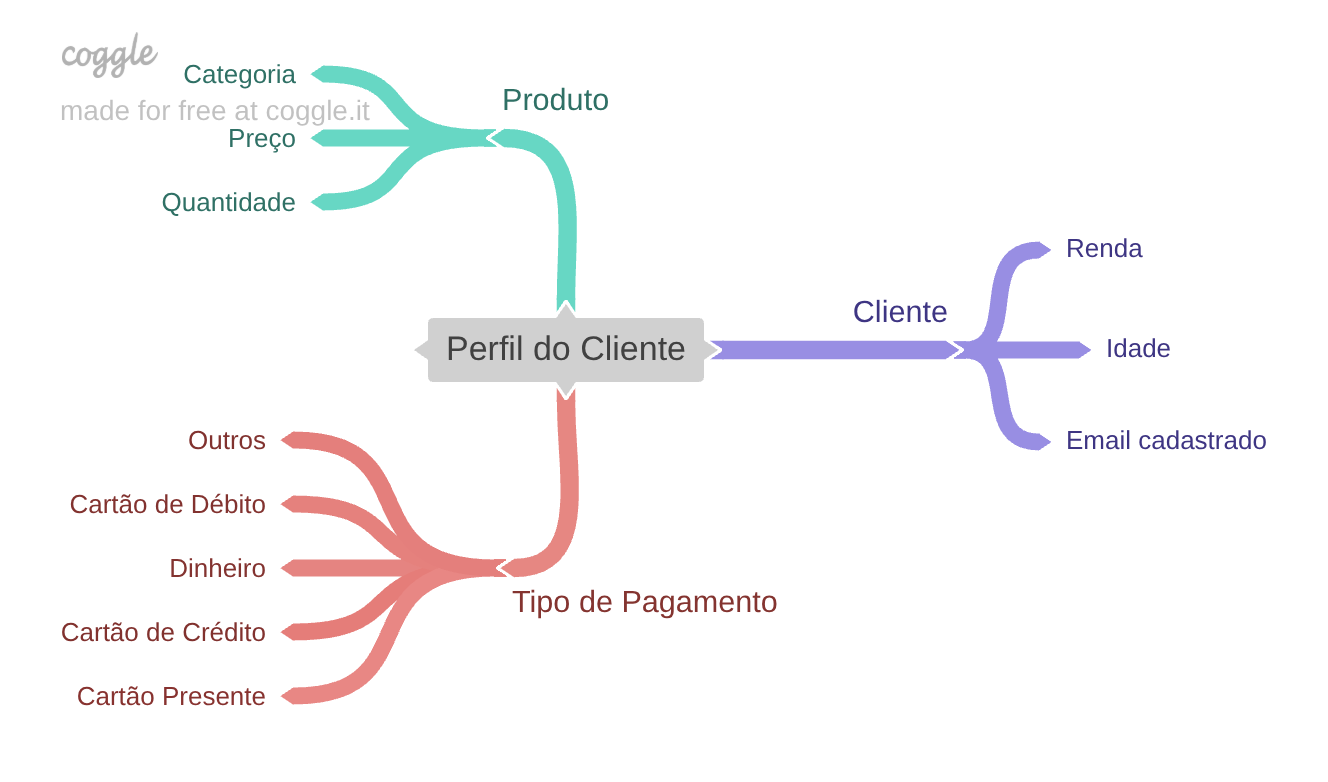

In [14]:
Image('Perfil_do_Cliente.png')

## 3.0 Análise Exploratória dos Dados

In [15]:
df3 = df2.copy()

### 3.1 Análise Univariada

In [16]:
df3.columns

Index(['customer_id', 'sales', 'units', 'orders', 'unique_products_bought',
       'unique_payments_used', 'unique_categories_bought', 'aov', 'aur', 'upt',
       'category_a_sales', 'category_b_sales', 'category_c_sales',
       'category_d_sales', 'category_e_sales', 'category_a_units',
       'category_b_units', 'category_c_units', 'category_d_units',
       'category_e_units', 'payment_cash', 'payment_credit', 'payment_debit',
       'payment_gc', 'payment_others', 'email_subscribed', 'omni_shopper',
       'age', 'hh_income'],
      dtype='object')

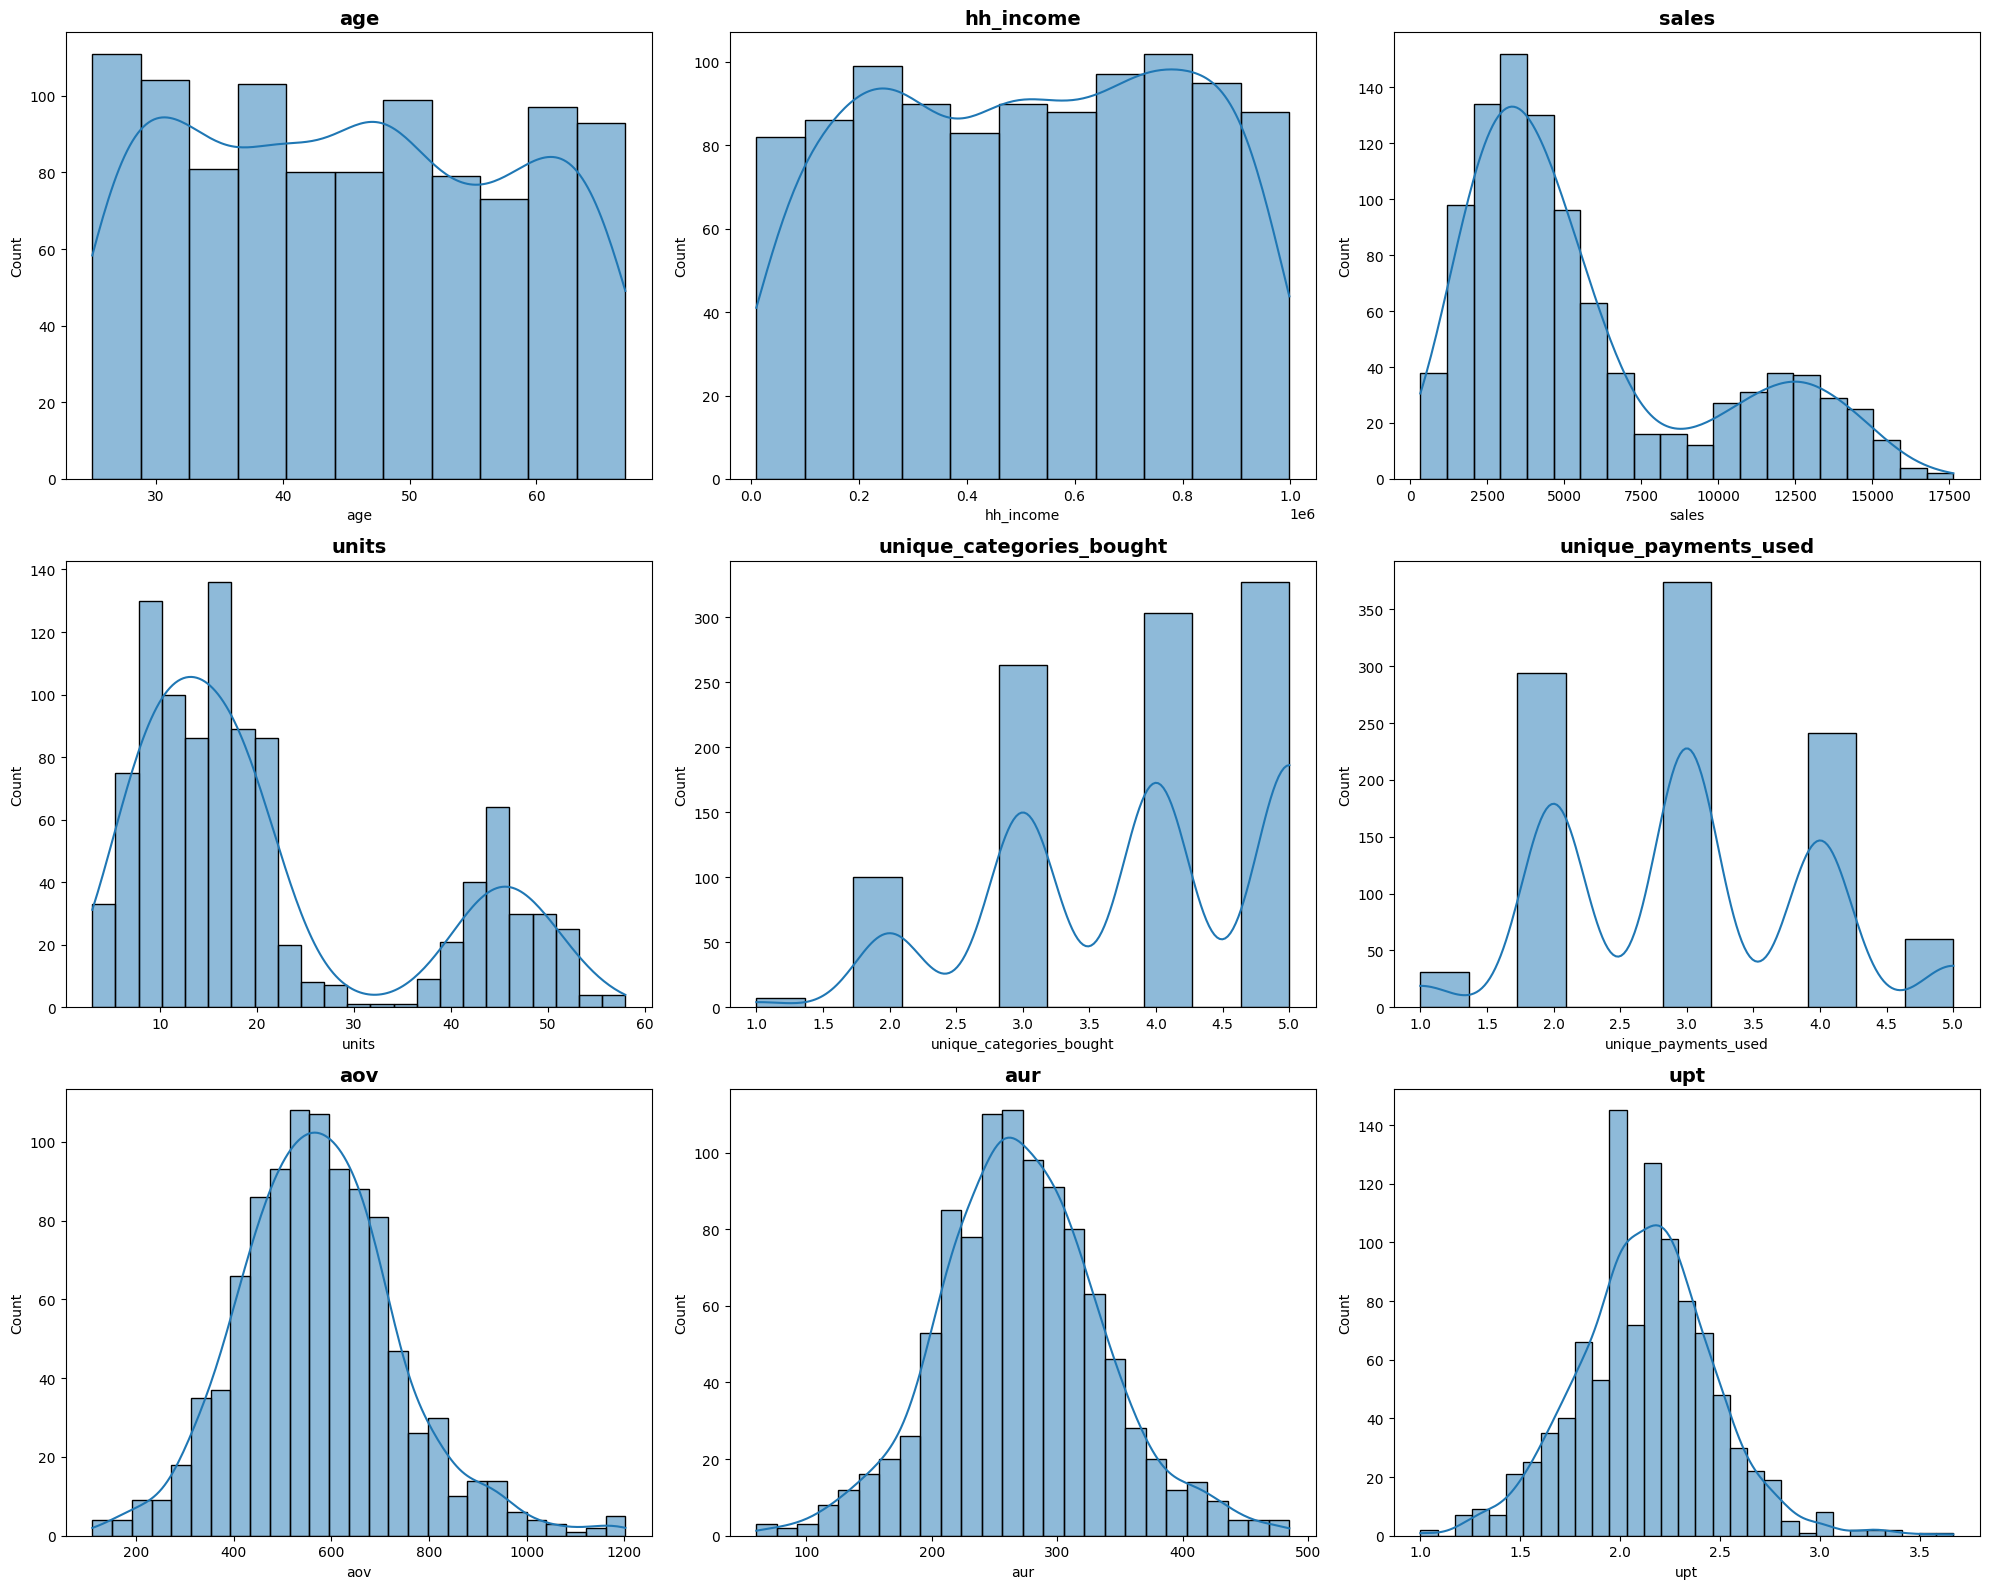

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(20, 16))

columns = ['age', 'hh_income', 'sales', 'units', 'unique_categories_bought',
           'unique_payments_used', 'aov', 'aur', 'upt']

# Achata a matriz de eixos para uma lista 1D
axes = axes.ravel()

for ax, col in zip(axes, columns):
    sns.histplot(df3[col], kde=True, ax=ax)
    ax.set_title(col, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.2 Análise Bivariada

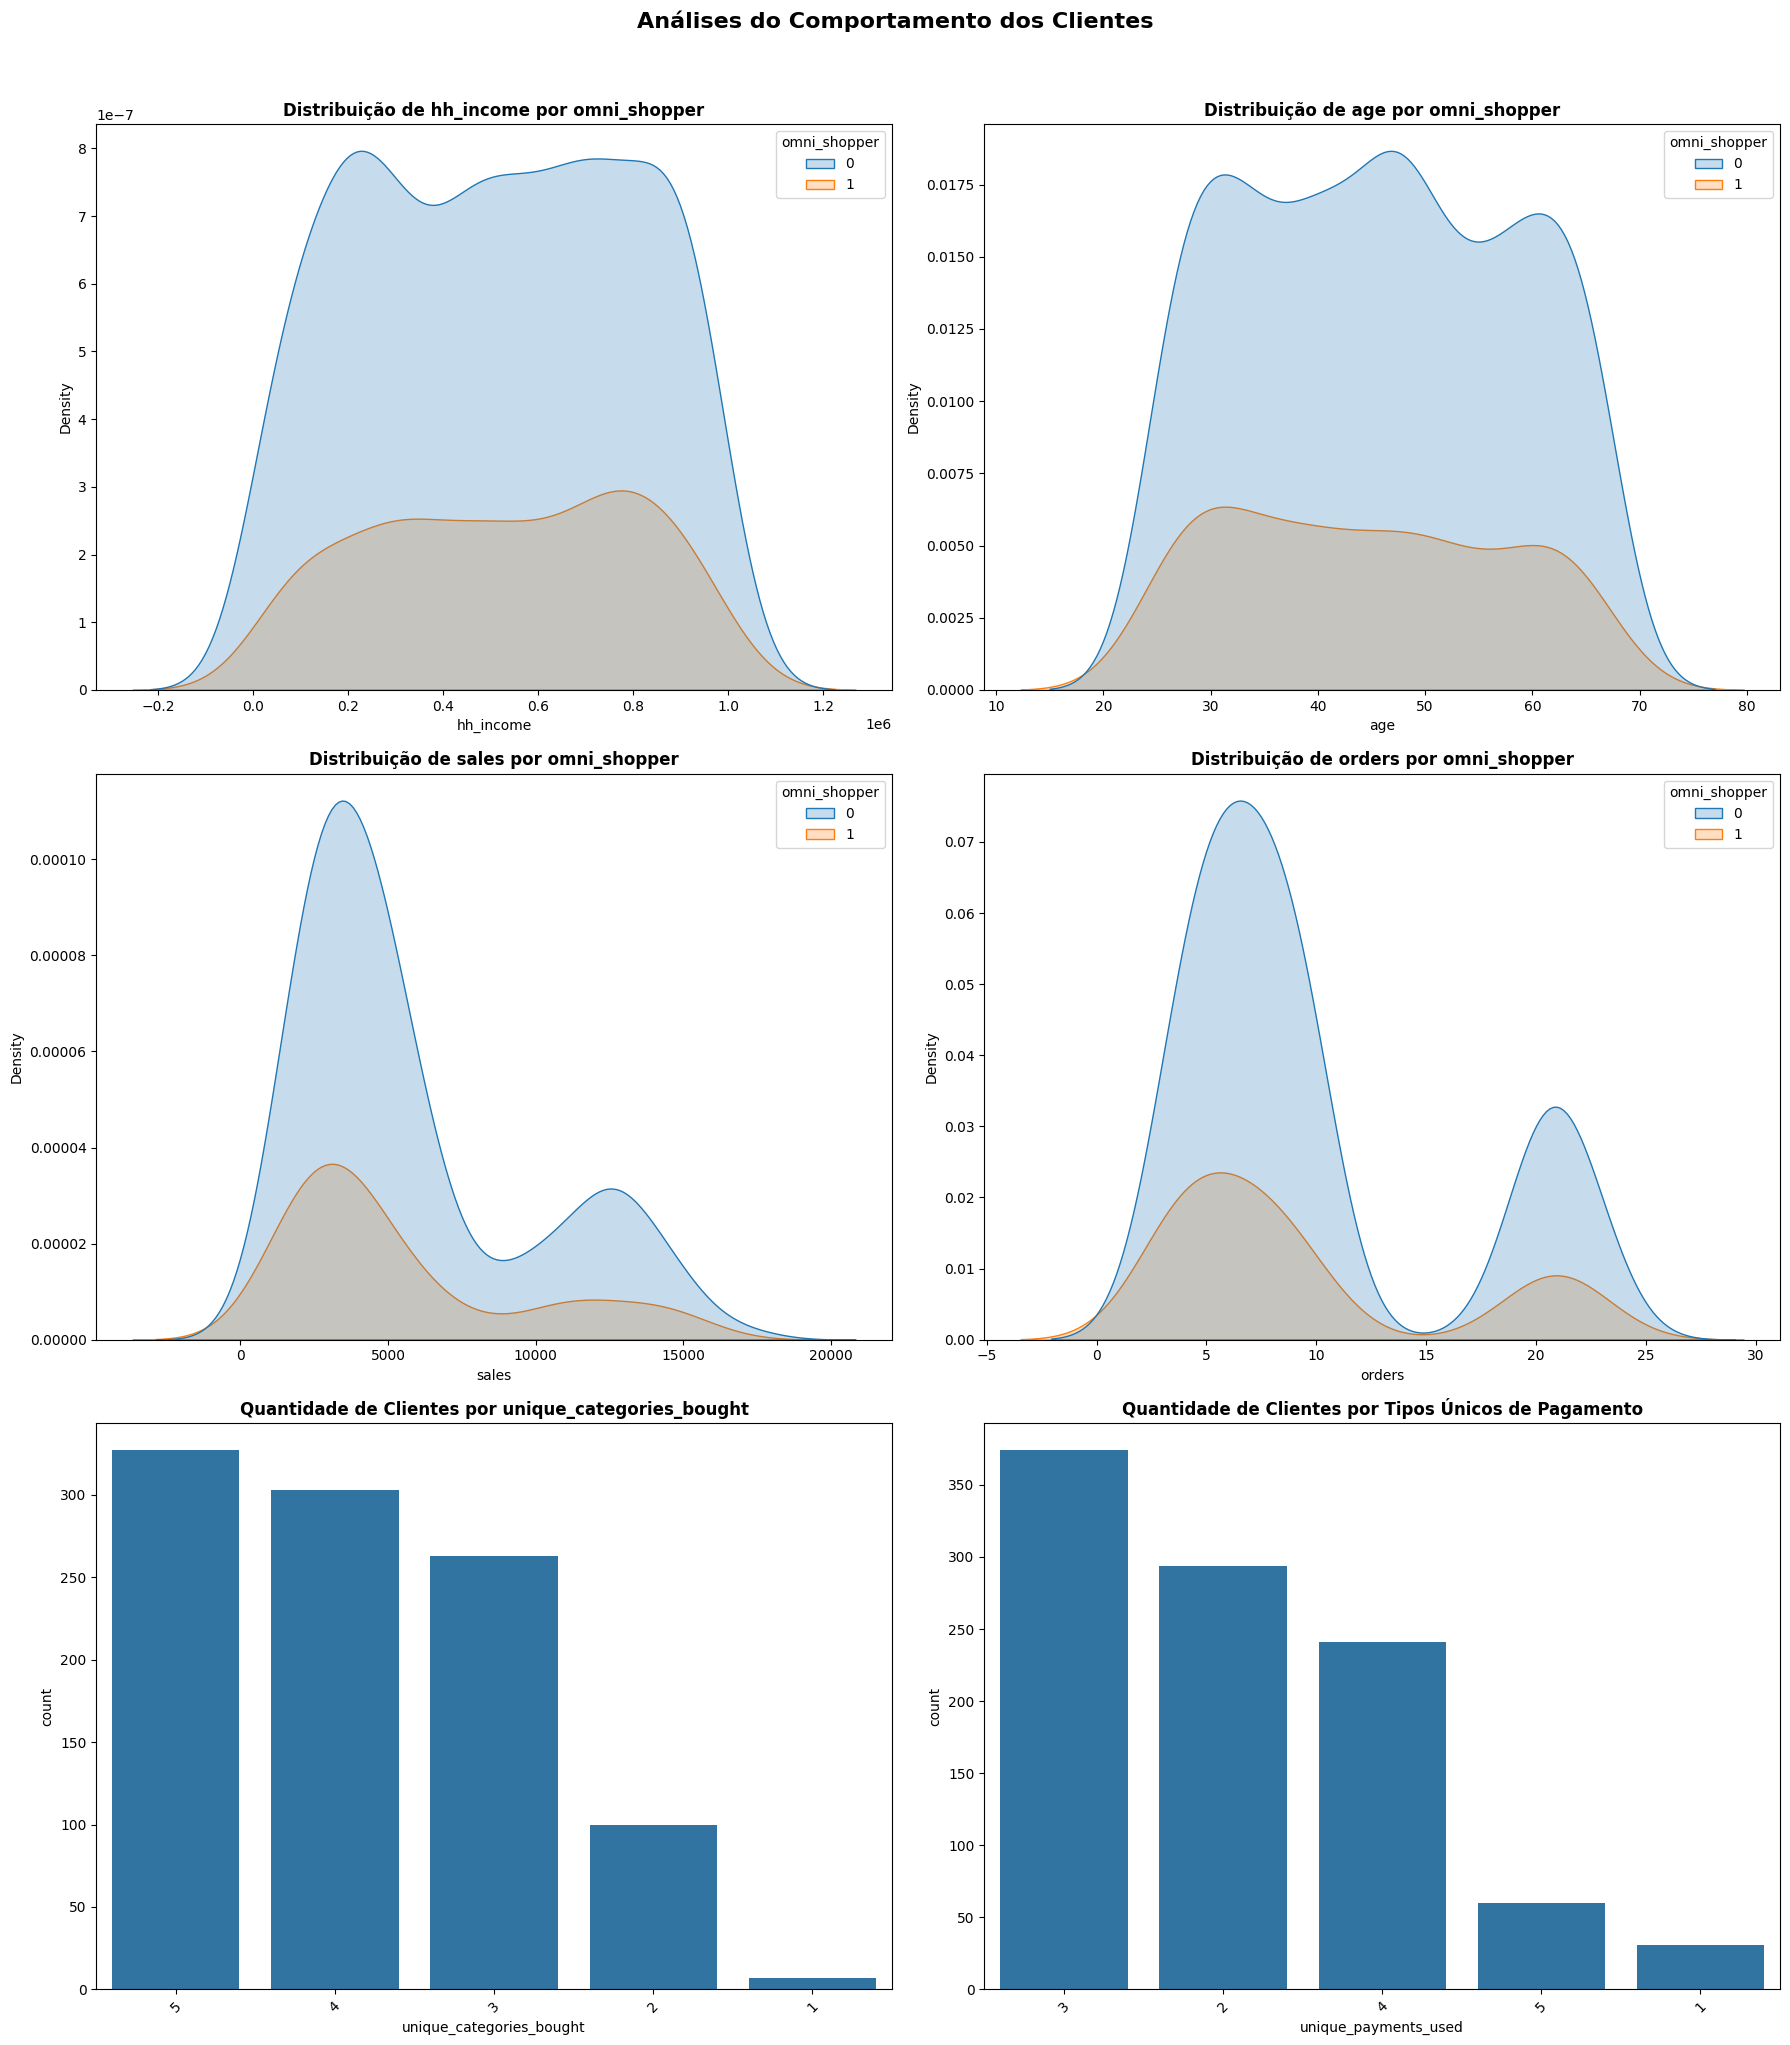

In [34]:
#Ajuste do tamanho da figura
fig, axes = plt.subplots(3,2, figsize= (18,20))
fig.suptitle('Análises do Comportamento dos Clientes', fontsize=16, y=1.02, fontweight='bold')

# 1.Gráfico de Dispersão da renda por omni_shopper
sns.kdeplot(data=df3, x='hh_income', hue='omni_shopper', fill=True, ax=axes[0,0])
axes[0,0].set_title('Distribuição de hh_income por omni_shopper', fontweight='bold')

# 2.Gráfico de Dispersão da idade por omni_shopper
sns.kdeplot(data=df3, x='age', hue='omni_shopper', fill=True, ax=axes[0,1])
axes[0,1].set_title('Distribuição de age por omni_shopper', fontweight='bold')

# 3.Gráfico de Dispersão do gasto por omni_shopper
sns.kdeplot(data=df3, x='sales', hue='omni_shopper', fill=True, ax=axes[1,0])
axes[1,0].set_title('Distribuição de sales por omni_shopper', fontweight='bold')

# 4.Gráfico de Dispersão das ordens por omni_shopper
sns.kdeplot(data=df3, x='orders', hue='omni_shopper', fill=True, ax=axes[1,1])
axes[1,1].set_title('Distribuição de orders por omni_shopper', fontweight='bold')

# 5.Gráfico de barras: quantidade de clientes por unique_categories_bought
sns.countplot(data=df3, x='unique_categories_bought', order=df3['unique_categories_bought'].value_counts().index, ax=axes[2,0])
axes[2,0].set_title('Quantidade de Clientes por unique_categories_bought', fontweight='bold')
axes[2,0].tick_params(axis='x', rotation=45)

# 6.Gráfico de barras: quantidade de clientes por estado civil
sns.countplot(data=df3, x='unique_payments_used', order=df3['unique_payments_used'].value_counts().index, ax=axes[2,1])
axes[2,1].set_title('Quantidade de Clientes por Tipos Únicos de Pagamento', fontweight='bold')
axes[2,1].tick_params(axis='x', rotation=45)

#Ajuste de layout
plt.tight_layout()
plt.show()

## 4.0 Modelagem dos Dados

In [53]:
df4 = df3.copy()

### 4.1 Data Filtering

In [54]:
df4.drop(columns = ['customer_id'], inplace = True)

### 4.2 Data Preparation

In [55]:
#Normalização Z-Score:

def normalizacao(df, col):
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val
    return df

# Lista de colunas a normalizar
colunas_para_normalizar = ['aov', 'aur', 'upt']

# Aplicando a normalização
for coluna in colunas_para_normalizar:
    df4 = normalizacao(df4, coluna)

In [56]:
#Min Max Scaler:

scalers = {}

for col in df4[['sales', 'units', 'orders', 'unique_products_bought',
       'unique_payments_used', 'unique_categories_bought', 
       'age', 'hh_income']].columns:
    mm = MinMaxScaler()
    df4[col] = mm.fit_transform(df4[[col]])
    scalers[col] = mm

with open('../scaler/scalers.pkl', 'wb') as file:
    pickle.dump(scalers,file)

### 4.3 Estudo de Espaço

In [66]:
X = df4.copy()

#### 4.3.1 PCA

Text(0.5, 1.0, 'PCA - Importância dos Principais Componentes')

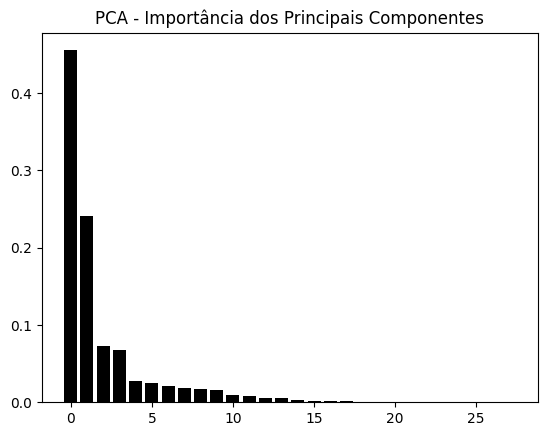

In [67]:
pca = dd.PCA(n_components = X.shape[1])

principal_components = pca.fit_transform(X)

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color = 'black')
plt.title('PCA - Importância dos Principais Componentes')

In [68]:
#Selecionando apenas as 2 primeiras colunas (mais importantes):

pca = dd.PCA(n_components=2)
pca.fit(X)
pca_ds = pd.DataFrame(pca.transform(X), columns = (['col1', 'col2']))

pca_ds

,col1,col2
0,-0.848904,0.572359
1,0.966990,-0.382133
2,-1.294500,0.511774
3,0.028467,0.016796
4,-0.129484,1.801261
...,...,...
995,0.800547,-1.195599
996,-0.660246,-0.743781
997,0.350144,-1.051605
998,-0.734355,-0.647346


Text(0.5, 1.0, 'PCA')

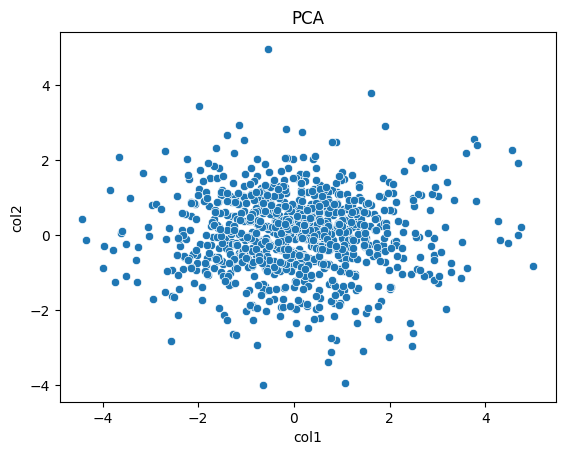

In [69]:
sns.scatterplot(x = 'col1', y = 'col2', data = pca_ds)
plt.title('PCA')

#### 4.3.2 T-SNE

In [70]:
reducer = mn.TSNE(n_components=2, n_jobs=1, random_state=42)
embedding = reducer.fit_transform(X)

df_tsne = pd.DataFrame(embedding)

Text(0.5, 1.0, 'T-SNE')

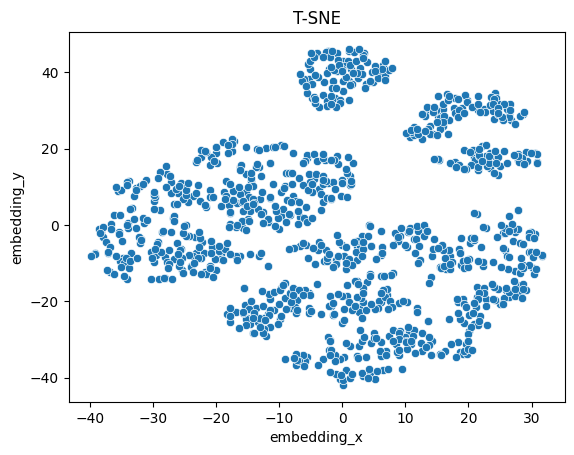

In [71]:
df_tsne = df_tsne.rename(columns = {0:'embedding_x', 1:'embedding_y'})

sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_tsne)
plt.title('T-SNE')

#### 4.3.3 UMAP

In [84]:
reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=0.0, low_memory=True)
embedding = reducer.fit_transform(X)

df_umap = pd.DataFrame(embedding)
df_umap = df_umap.rename(columns={0:'embedding_x', 1:'embedding_y'})

c:\Users\samso\anaconda3\envs\projeto_cluster\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'UMAP')

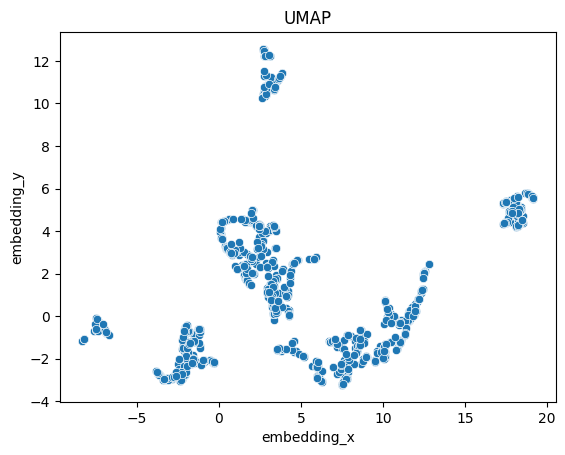

In [85]:
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap)
plt.title('UMAP')

## 5.0 Modelling

In [58]:
df5 = df4.copy()
clusters = np.arange(2,50,1)

### 5.1 KMEANS

In [61]:
kmeans_list = []

for k in clusters:
    kmeans_model  = c.KMeans(n_clusters=k)
    kmeans_model.fit(df5)
    labels = kmeans_model.predict(df5)
    sil = m.silhouette_score(df5, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0, 0.5, 'Silhouette Score')

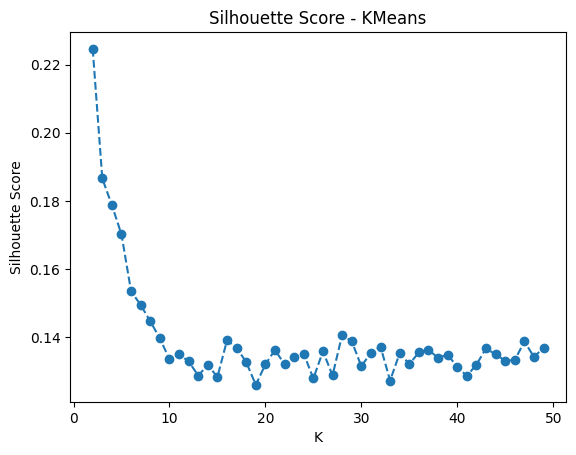

In [62]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o')
plt.title('Silhouette Score - KMeans')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

### 5.2 GMM

In [63]:
gmm_list = []

for k in clusters:
    gmm_model  = mx.GaussianMixture(n_components=k)
    gmm_model.fit(df5)
    labels = gmm_model.predict(df5)
    sil = m.silhouette_score(df5, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0, 0.5, 'Silhouette Score')

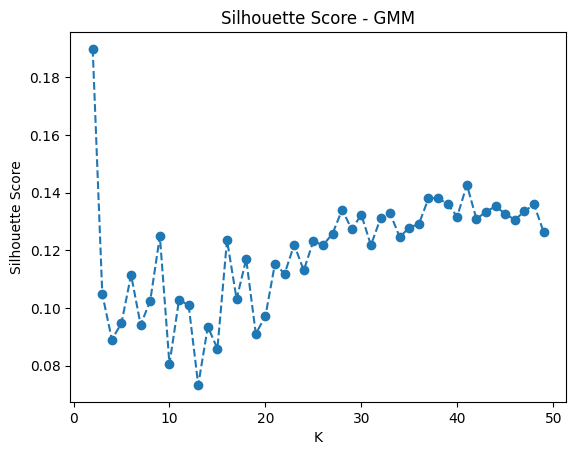

In [64]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o')
plt.title('Silhouette Score - GMM')
plt.xlabel('K')
plt.ylabel('Silhouette Score')